In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from tqdm import tqdm
import torch
import numpy as np
from argparse import Namespace

from env.KREnvironment_SlateRec import KREnvironment_SlateRec

output_path = 'output/Kuairand_Pure/env/log/'
# uirm_log_path = output_path + 'user_KRMBUserResponse_lr0.0001_reg0_nlayer2.model.log'
uirm_log_path = output_path + 'user_KRMBUserResponseWithBias_lr0.0003_reg0_nlayer2.model.log'

slate_size = 6
max_step = 10
ep_batch_size = 16
initial_temper = max_step
rho = 0.1
args = eval(f"Namespace(uirm_log_path='{uirm_log_path}', slate_size={slate_size}, \
            max_step_per_episode={max_step}, episode_batch_size={ep_batch_size}, \
            initial_temper={initial_temper}, item_correlation={rho}, device='cpu', \
            single_response=True)")

env = KREnvironment_SlateRec(args)

Environment arguments: 
Namespace(seed=619607, lr=0.0003, batch_size=128, val_batch_size=128, test_batch_size=128, save_with_val=False, epoch=10, cuda=1, model_path='output/Kuairand_Pure/env/user_KRMBUserResponseWithBias_lr0.0003_reg0_nlayer2.model', loss='bce', l2_coef=0.0, user_latent_dim=32, item_latent_dim=32, enc_dim=64, attn_n_head=4, transformer_d_forward=64, transformer_n_layer=2, state_hidden_dims=[128], scorer_hidden_dims=[128, 32], dropout_rate=0.1, train_file='dataset/Kuairand_Pure/log_session_4_08_to_5_08_Pure.csv', val_file='', test_file='', n_worker=4, data_separator=',', user_meta_file='dataset/Kuairand_Pure/user_features_Pure_fillna.csv', item_meta_file='dataset/Kuairand_Pure/video_features_basic_Pure_fillna.csv', max_hist_seq_len=100, val_holdout_per_user=5, test_holdout_per_user=5, meta_file_sep=',')
Loading raw data
Load user sequence reader
initiate KuaiRandMultiBehaior sequence reader
Loading data files
Load item meta data
Load user meta data
build vocab for oneho

100%|██████████| 13/13 [00:00<00:00, 1121.10it/s]


build vocab for onehot features


100%|██████████| 3/3 [00:00<00:00, 1740.86it/s]


build vocab for multihot features:
	tag


100%|██████████| 7583/7583 [00:00<00:00, 1564918.68it/s]

sequence holdout for users (-1, 0, 0)
{'raw_data_size': 1341250, 'data_size': [1341250, 0, 0], 'n_user': 19574, 'n_item': 5659, 'max_seq_len': 100, 'user_features': ['user_active_degree', 'is_live_streamer', 'is_video_author', 'follow_user_num_range', 'fans_user_num_range', 'friend_user_num_range', 'register_days_range', 'onehot_feat0', 'onehot_feat1', 'onehot_feat6', 'onehot_feat9', 'onehot_feat10', 'onehot_feat11'], 'user_feature_dims': {'user_active_degree': 9, 'is_live_streamer': 2, 'is_video_author': 2, 'follow_user_num_range': 8, 'fans_user_num_range': 9, 'friend_user_num_range': 7, 'register_days_range': 8, 'onehot_feat0': 2, 'onehot_feat1': 7, 'onehot_feat6': 3, 'onehot_feat9': 7, 'onehot_feat10': 5, 'onehot_feat11': 5}, 'item_features': ['video_type', 'music_type', 'upload_type', 'tag'], 'item_feature_dims': {'video_type': 3, 'music_type': 6, 'upload_type': 14, 'tag': 47}, 'feedback_type': ['is_click', 'long_view', 'is_like', 'is_comment', 'is_forward', 'is_follow', 'is_hate']

Setup candidate item pool


### User Profile and User History in the Observation Dict

In [3]:
from utils import show_batch, wrap_batch

observation = env.reset({'batch_size': ep_batch_size})
show_batch(env.current_observation['user_profile'])

user_id: size torch.Size([16]), 
	first 5 tensor([  238, 18185,  5031,  1046, 16277])
uf_user_active_degree: size torch.Size([16, 9]), 
	first 5 tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.]])
uf_is_live_streamer: size torch.Size([16, 2]), 
	first 5 tensor([[0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.]])
uf_is_video_author: size torch.Size([16, 2]), 
	first 5 tensor([[0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.]])
uf_follow_user_num_range: size torch.Size([16, 8]), 
	first 5 tensor([[0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.]])
uf_fans_user_num_range: size torch.Size([16, 9]), 
	firs

In [4]:
from utils import show_batch, wrap_batch
show_batch(env.current_observation['user_history'])

history: size torch.Size([16, 100]), 
	first 5 tensor([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,  248],
        [ 281,  576, 3692,   94,  382,   77,  362, 2323,  815, 1724,  626,  915,
         1153, 1849, 1849, 1213, 1445,  604, 1463, 1292, 1330,  356,  320, 2805,
         2359,  426,  953,  377, 2300, 1817, 1479, 1167, 2261,  193,  823, 1271,
          440, 3038,    6, 4

### Random Interaction

In [5]:
from tqdm import tqdm
import torch

N = len(env.candidate_iids) # number of candidates

feedback_history = {f: [] for f in env.response_types}

for i in tqdm(range(20)):
#     action = torch.randn(BS,env.action_dim)
    action = torch.randint(0,N,(ep_batch_size, env.action_dim))
    new_observation, user_feedback, updated_observation = env.step({'action': action})
    # (B, slate_size, n_feedback)
    response = user_feedback['immediate_response']
    for i,f in enumerate(env.response_types):
        feedback_history[f].append(torch.mean(response[:,:,i], dim=1).numpy())
    observation = new_observation
env.stop()

100%|██████████| 20/20 [00:04<00:00,  4.03it/s]


list of feedbacks:  ['is_click', 'long_view', 'is_like', 'is_comment', 'is_forward', 'is_follow', 'is_hate']


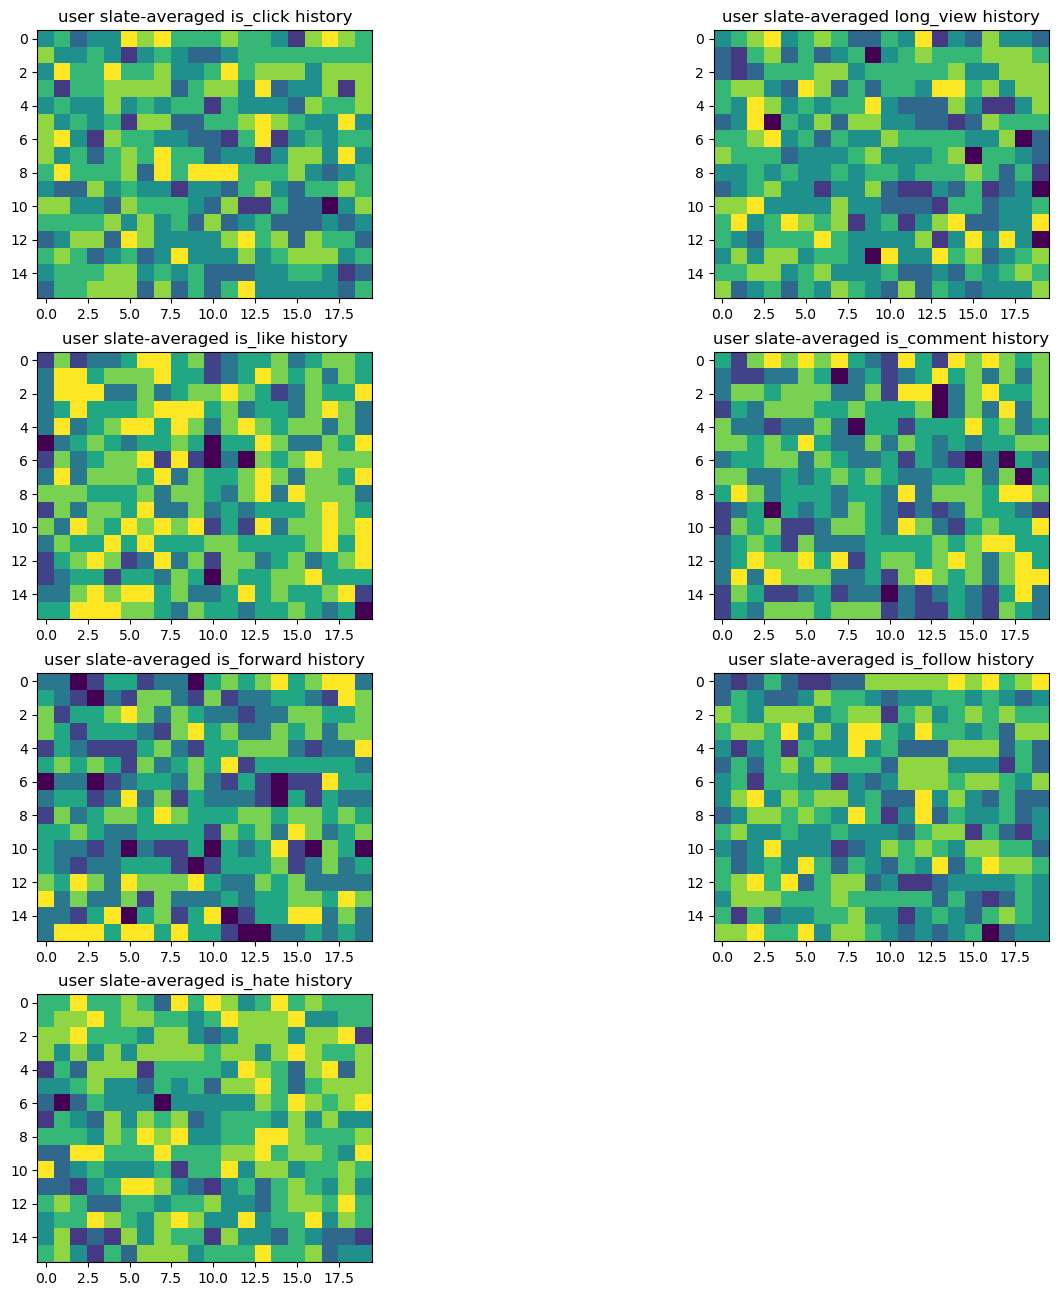

In [12]:
import numpy as np
import matplotlib.pyplot as plt
# selected_feedbacks = ['is_click', 'long_view', 'is_forward']
selected_feedbacks = env.response_types
n_row = (len(selected_feedbacks)+1)//2
plt.figure(figsize = (16,4*n_row))
print('list of feedbacks: ', selected_feedbacks)
for i,f in enumerate(selected_feedbacks):
    H = np.transpose(np.array(feedback_history[f]))
    plt.subplot(n_row,2,i+1)
    plt.imshow(H)
    plt.title(f'user slate-averaged {f} history')
plt.show()

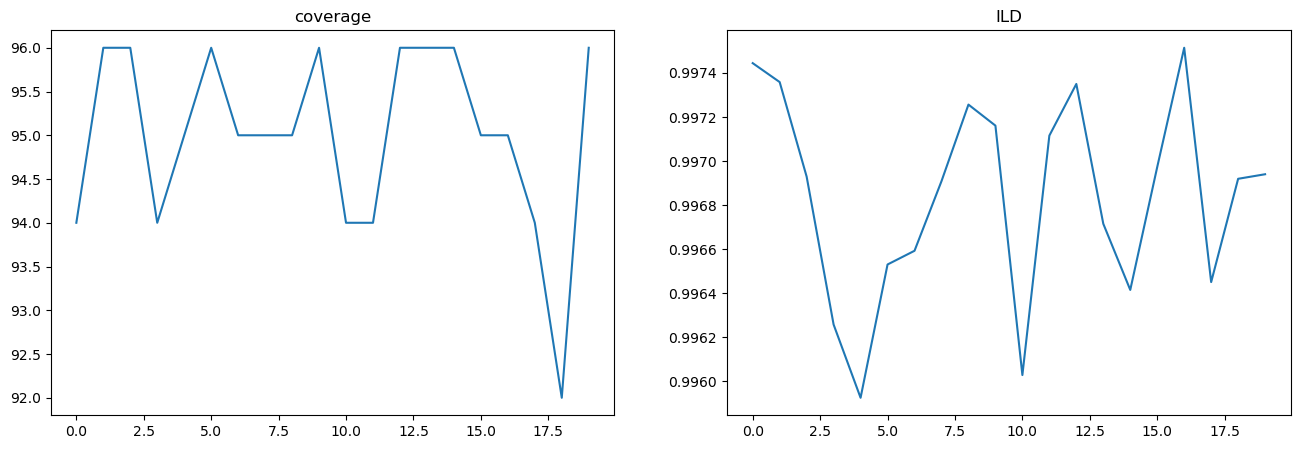

In [13]:
env_observation_list = ['coverage', 'ILD']
n_row = (len(env_observation_list)+1)//2
plt.figure(figsize = (16, 1+4*n_row))
for i,k in enumerate(env_observation_list):
    plt.subplot(n_row,2, i+1)
    plt.plot(env.env_history[k])
    plt.title(k)
plt.show()

### Example of User Response

In [14]:
user_feedback.keys()

dict_keys(['immediate_response', 'user_state', 'coverage', 'ILD', 'done'])

In [15]:
user_feedback['user_state'].shape

torch.Size([16, 1, 192])

In [16]:
print('coverage:', user_feedback['coverage'])
print('intra list diversity:', user_feedback['ILD'])
print('done signal:', user_feedback['done'])

coverage: 96
intra list diversity: 0.99694022256881
done signal: tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True])


In [17]:
# (episode_batch_size, slate_size, n_response_types)
print(user_feedback['immediate_response'].shape)
print(user_feedback['immediate_response'])

torch.Size([16, 6, 7])
tensor([[[1., 0., 1., 0., 1., 1., 1.],
         [0., 0., 0., 1., 0., 1., 1.],
         [1., 0., 0., 1., 0., 1., 1.],
         [1., 1., 1., 1., 1., 1., 0.],
         [0., 0., 1., 1., 1., 1., 0.],
         [1., 1., 1., 1., 0., 1., 1.]],

        [[1., 1., 1., 1., 1., 1., 1.],
         [1., 0., 1., 1., 1., 0., 0.],
         [0., 1., 0., 1., 1., 1., 1.],
         [1., 1., 1., 1., 0., 1., 1.],
         [1., 1., 1., 1., 1., 0., 1.],
         [0., 0., 0., 0., 1., 0., 0.]],

        [[1., 1., 1., 1., 1., 1., 0.],
         [1., 1., 1., 0., 1., 1., 0.],
         [1., 1., 1., 1., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1.],
         [0., 1., 1., 1., 1., 1., 0.],
         [1., 0., 1., 1., 1., 0., 0.]],

        [[1., 0., 1., 1., 1., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 0., 0., 0., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 0., 1., 1., 1., 1.],
         [0., 1., 0., 1., 1., 1., 1.]],

        [[0., 1., 0., 1., 1., 0.,

In [18]:
action.shape, action

(torch.Size([16, 6]),
 tensor([[4564, 1909, 4628, 2092, 5028,  286],
         [1967, 4922, 1066,   59, 3298,  585],
         [4144, 1188, 3942, 4234, 3149, 2029],
         [2921, 2568, 3175, 4863, 2095, 3680],
         [3049, 5540,  722, 2974, 2428, 2885],
         [1978, 1255, 2545, 1680, 1601,  752],
         [1113, 3399, 1262, 2108, 4118, 5468],
         [3563,    4, 2849, 3102, 2854, 1822],
         [2574,  450, 4804, 2495, 4942,  277],
         [4882, 1120, 5279, 1530, 2274,  370],
         [ 703,  607, 4699,  462, 2258,  337],
         [4471, 5537, 5643, 5606, 3976,  570],
         [1432, 3193, 1694, 2905,  603, 4765],
         [4049, 5066, 1711, 2297,    8, 1930],
         [ 684, 1809,  396, 4742, 2361, 3388],
         [1070, 4193, 1750, 5474, 2717, 4008]]))